# Part II

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp

In [19]:
def k(x,y):
  # Returns the result of Euclidiean kernel k(x,y) 
  return np.exp(-np.linalg.norm(x-y)**2)

def compute_K(X,Y):
    # Computes the matrix K = (k(x,y))
    return np.array([[k(Xi,Yj) for Yj in Y] for Xi in X])

def plot_f(alpha,x_selected,x):
    # Returns the evaluation of the function f defined by alpha at points x
    K = compute_K(x,x_selected)
    return K@alpha

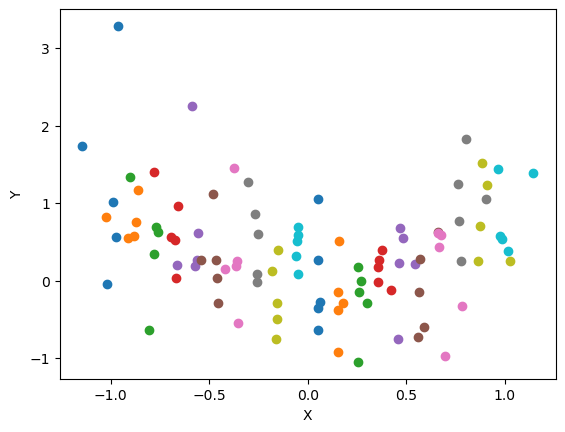

In [3]:
n = 100
m = 10
a = 5

with open('../databases/second_database.pkl', 'rb') as f:
    X, Y = pkl.load(f)
    
plt.plot(X,Y,'o')
plt.xlabel("X")
plt.ylabel("Y")

X = np.array(X)
Y = np.array(Y)

x_m_points=np.linspace(-1,1,m)

## FedAvg

In this part, we want rewrite the initial problem as follows :
$$\underset{\alpha \in \mathbb{R}^m}{\text{argmin}} ~\mathbb{E}_{x,y}\left[\frac{1}{2\sigma^2}\|y - K(x)^T\alpha\|^2  + \frac{1}{2}\alpha^TK_{m,m}\alpha\right]$$
where $K(x) = \begin{pmatrix}k(x,x_1)\cdots k(x,x_m)\end{pmatrix}^T$, $(x_i)_{i\in \{1,...,m\}}$ are the points in $\mathcal{M}$ and $K_{m,m} = [k(x_i,x_j)]_{i,j\in \{1,...,m\}}$.

So, by denoting $g_j(\alpha) = \frac{1}{2\sigma^2}\|y_j - K(x_j)^T\alpha\|^2  + \frac{1}{2}\alpha^TK_{m,m}\alpha$, we have 
$$\nabla g_j(\alpha) = K_{m,m}\alpha- \frac{1}{\sigma^2}K(x_j)(y_j - K(x_j)^T\alpha)$$

For the `FedAvg` algorithm, the update of $\alpha_{k+1}$ is done as follows :
$$\alpha_{k+1} = \sum_{c = 1}^C \frac{N_c}{\sum_{c'=1}^C N_{c'}}\alpha_{k+1}^c$$
In our case, all clients have the same number of points : $N$, so the coefficient $\frac{N_c}{\sum_{c'=1}^C N_{c'}} = \frac{N}{CN} = \frac{1}{C}$.

We need a diminishing learning rate so we choose as learning rate the sequence : $(1/k)_{k\in \mathbb{N}^*}$.

In [4]:
def compute_K_x_j(x_m_points,x_j):
    return np.array([k(x_m_points[i],x_j) for i in range(len(x_m_points))])
    

In [35]:
def client_update(X,Y,index_client,E,sigma,alpha_0,K_mm):
    m = K_mm.shape[0]
    alpha = np.copy(alpha_0)
    for k in range(E):
        random_batch = np.random.randint(X.shape[1])
        x_j = X[index_client,random_batch]
        y_j = Y[index_client,random_batch]
        K_x_j = compute_K_x_j(x_m_points,x_j)
        alpha -= (1/(k+1))*((K_mm@alpha) - (y_j - K_x_j.T@alpha)*K_x_j/(sigma**2))
    return alpha

In [38]:
def FedAvg(X,Y,B,E,C,sigma,nb_it,K_mm):
    nb_clients = X.shape[0]
    m = K_mm.shape[0]

    alpha = np.zeros(m)
    for k in tqdm(range(nb_it)):
        selected_clients = np.random.choice(np.array(range(nb_clients)),size=C, replace=False)
        alpha_i = np.zeros((C,m))
        for i in range(C):
            alpha_i[i] = client_update(X,Y,selected_clients[i],E,sigma,alpha,K_mm)
        
        #We need to update x_{k+1} = \sum_{c = 1}^C
        alpha = np.sum(alpha_i,axis=0)/C
    return alpha

In [41]:
K_mm = compute_K(x_m_points,x_m_points)
B = 10
E = 10
C = 3
nb_it = 10
sigma = 0.5
alpha_res = FedAvg(X,Y,B,E,C,sigma,nb_it,K_mm)

100%|██████████| 10/10 [00:00<00:00, 451.63it/s]


In [42]:
alpha_res

array([5.98914236e+50, 9.72866323e+50, 1.40930534e+51, 1.89327759e+51,
       2.40649294e+51, 2.91084455e+51, 3.33591085e+51, 3.58872689e+51,
       3.58885443e+51, 3.30983948e+51])

Text(0.5, 1.0, 'Plot of $f$ using FedAvg to solve the problem')

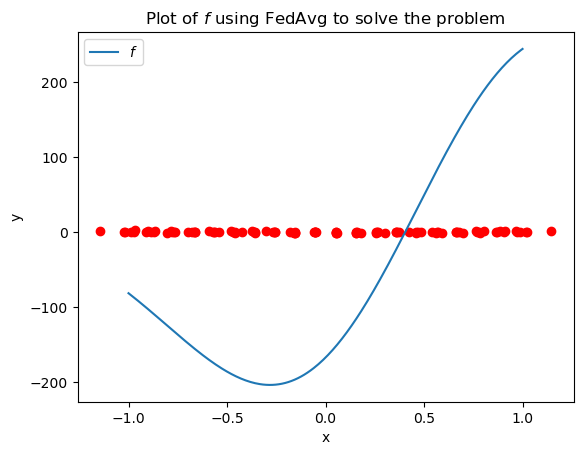

In [34]:
s = 250
x_prime = np.linspace(-1,1,s)
f_approx_fedavg = plot_f(alpha_res,x_m_points,x_prime)
plt.plot(X,Y,'ro')
plt.plot(x_prime,f_approx_fedavg, label= "$f$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Plot of $f$ using FedAvg to solve the problem")